In [1]:
import itertools
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from softcvi_validation import utils
from softcvi_validation.tasks.available_tasks import get_available_tasks

hyparam_str="k=8_negative=proposal"  # This can be altered to plot for other hyperparams
os.chdir(utils.get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')
palette = utils.get_palette()

tasks = get_available_tasks()
method_names = [k for k in palette.keys() if k not in ["True", "SoftCVI(a=0)"]]

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.3,
}

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items() if k in method_names
]

In [2]:
metric_names = [
    "mean_log_prob_reference",
    "negative_posterior_mean_l2",
    "coverage_probabilities",
    "run_time",
]

results = {
    "task_name": [],
    "method_name": [],
    "metric": [],
    "value": [],
}

plot_task_names = {
    "eight_schools": "Eight\nSchools",
    "linear_regression": "Linear\nRegression",
    "slcp": "SLCP",
    "garch": "GARCH",
}

coverage_results = {
    method_name: {} for method_name in method_names 
}

for task_name, method_name, metric in itertools.product(
    tasks.keys(), method_names, metric_names,
    ):
    cov_probs = []

    for seed in range(1, 51):
        file = (
            f"results/{task_name}/metrics/"
            f"{method_name}_seed={seed}_{hyparam_str}.npz"
            )
        value = dict(np.load(file))[metric]
        
        if metric != "coverage_probabilities":
            results["task_name"].append(task_name)
            results["method_name"].append(method_name)
            results["metric"].append(metric)
            results["value"].append(value)
        else:
            cov_probs.append(value)
            
    if metric == "coverage_probabilities":
        coverage_results[method_name][task_name] = np.stack(cov_probs)
        
df = pd.DataFrame(results)
df["task_name"] = df["task_name"].replace(plot_task_names)
df["value"] = df["value"].astype(float)


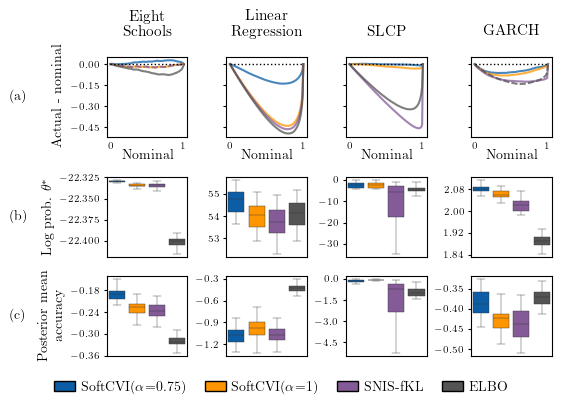

In [3]:
# We put the legend in its own subfigure, otherwise it is cut off when saving.
# We could use "bbox_inches="tight", but we want figure width == \textwidth
total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 4),
    )

fig, legend_fig = total_fig.subfigures(
    nrows=2,
    height_ratios=[10, 1],
    )

axes = fig.subplots(nrows=3, ncols=len(tasks))

# Convert axes to a more convenient structure
coverage_axes, log_prob_axes, posterior_mean_axes = axes


def will_overlap(y, previous_ys, threshold=0.01):
    if len(previous_ys) == 0:
        return False
    return any(np.mean(np.abs(y-py)) < threshold for py in previous_ys)

####### Coverage ######
nominal_frequency = np.linspace(0, 1, 100)

for task_name, ax in zip(plot_task_names.keys(), coverage_axes, strict=True):

    ax.set_title(plot_task_names[task_name], y=1.15)
    ax.set_xlabel("Nominal", labelpad=0)

    prev_diffs = []
    for method_name in method_names:
        coverage_probs = coverage_results[method_name][task_name]
        diff = np.mean(coverage_probs, axis=0) - nominal_frequency
        ax.plot(
            nominal_frequency,
            diff,
            color=palette[method_name],
            alpha=0.75,
            linewidth=1.5,
            linestyle=(0, (3, 1)) if will_overlap(diff, prev_diffs) else "-",
        )
        prev_diffs.append(diff)

    ax.plot([0, 1], [0, 0], color="black", linewidth=1, linestyle="dotted")


####### log prob true #######
for task_name, ax in zip(plot_task_names.values(), log_prob_axes, strict=True):
    lp_df = df.loc[
        (df.metric == "mean_log_prob_reference") & (df.task_name == task_name), 
        ]
    sns.boxplot(lp_df, x="method_name", y="value", hue="method_name", ax=ax, **box_kwargs)

### Negative posterior mean l2 ###
for task_name, ax in zip(plot_task_names.values(), posterior_mean_axes, strict=True):
    l2_df = df.loc[
        (df.metric == "negative_posterior_mean_l2") & (df.task_name == task_name), 
        ]
    sns.boxplot(
        l2_df, x="method_name", y="value", hue="method_name", ax=ax, **box_kwargs,
        )
   
[ax.set_xlabel(None) for ax in axes.ravel()]
[ax.set_ylabel(None) for ax in axes.ravel()]

coverage_axes[0].set_ylabel("Actual - nominal")
[ax.set_xlabel("Nominal") for ax in coverage_axes]
log_prob_axes[0].set_ylabel(r"Log prob. $\theta^*$")
posterior_mean_axes[0].set_ylabel("Posterior mean \n accuracy")

for ax in axes.ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_box_aspect(1)
    ax.tick_params(axis="x", which="major", length=0)

for axs in [log_prob_axes, posterior_mean_axes]:
    for ax in axs:
        ax.tick_params("x", bottom=False)
        ax.xaxis.set_ticklabels([])

legend_fig.legend(handles=handles, ncols=4)

# Loop through the rows and label each one
for letter, ax in zip(["a", "b", "c"], axes[:, 0], strict=True):
    ax.text(-1.2, 0.5, f"({letter})", transform=ax.transAxes, va='center')

# Manually share axes for first row only
[a1.sharey(a2) for a1, a2 in zip(coverage_axes[:-1], coverage_axes[1:], strict=True)]
[ax.get_yaxis().set_ticklabels([]) for ax in coverage_axes[1:]]

total_fig.savefig(f"plots/plots/metrics_{hyparam_str}.pdf")


### Run times

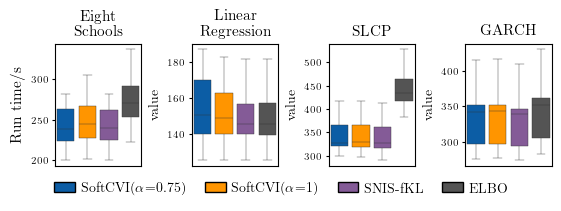

In [4]:
# We put the legend in its own subfigure, otherwise it is cut off when saving.
# We could use "bbox_inches="tight", but we want figure width == \textwidth
total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 2),
    )
fig, legend_fig = total_fig.subfigures(nrows=2, height_ratios=[5, 1])
axes = fig.subplots(ncols=len(tasks))

for task_name, ax in zip(plot_task_names.values(), axes, strict=True):
    runtimes = df.loc[(df["metric"] == "run_time") & (df["task_name"] == task_name)]
    sns.boxplot(runtimes, x="method_name", y="value", hue="method_name", ax=ax, **box_kwargs)
    ax.set_title(task_name.replace("_", "\n")) 

[ax.set_xlabel(None) for ax in axes.ravel()]
axes[0].set_ylabel("Run time/s", fontsize=11)
legend_fig.legend(handles=handles, ncols=4)

for ax in axes:
    ax.tick_params("x", bottom=False)
    ax.xaxis.set_ticklabels([])

total_fig.savefig(f"plots/plots/run_times_{hyparam_str}.pdf")

### Log prob with k

In [5]:
loop = itertools.product(
    plot_task_names.keys(),
    method_names,
    range(50),
    (2, 4, 8, 16, 32, 64),
)

results = {
    "task": [],
    "method": [],
    "k": [],
    "log_prob": [],
    "run_time": [],
}

for task_name, method_name, seed, k in loop:
    file = (
        f"results/{task_name}/metrics/"
        f"{method_name}_seed={seed}_k={k}_negative=proposal.npz"
            )
    res_i = dict(np.load(file))
    lp_i = res_i["mean_log_prob_reference"].item()
    runtime_i = res_i["run_time"].item()
    results["task"].append(task_name)
    results["method"].append(method_name)
    results["k"].append(k)
    results["log_prob"].append(lp_i)
    results["run_time"].append(runtime_i)


In [6]:
lp_with_k_df = pd.DataFrame(results)
lp_with_k_df = lp_with_k_df.groupby(["k", "method", "task"], as_index=False).mean()

/tmp/ipykernel_82967/3161020600.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  total_fig.show()


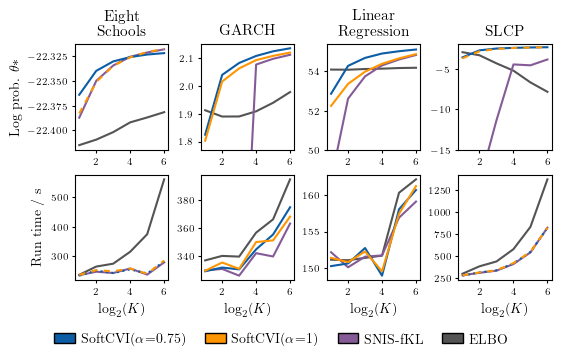

In [7]:
total_fig = plt.figure(
    layout='constrained',
    figsize=(plt.rcParams['figure.figsize'][0], 3.5),
    )

fig, legend_fig = total_fig.subfigures(
    nrows=2,
    height_ratios=[10, 1],
    )

axes = fig.subplots(nrows=2, ncols=len(tasks))

tasks = lp_with_k_df["task"].unique()

for lp_ax, rt_ax, task in zip(axes[0], axes[1], tasks, strict=True):
    task_data = lp_with_k_df[lp_with_k_df["task"] == task]
    
    # Group by "method" to plot separate lines
    for method_name, method_data in task_data.groupby("method"):
        overlapping = ("eight_schools", "slcp")

        if method_name=="SoftCVI(a=1)" and task in overlapping:
            linestyle=(0, (3, 3))
        else:
            linestyle="solid"
        lp_ax.plot(
            np.log2(method_data["k"].to_numpy()),
            method_data["log_prob"],
            linewidth=1.5,
            color=palette[method_name],
            linestyle=linestyle,
            )
        
        if task in overlapping:
            if method_name=="SoftCVI(a=1)":
                linestyle=(0, (3, 3))
            elif method_name=="SoftCVI(a=0.75)":
                linestyle="dotted"
            else:
                linestyle="solid"
        else:
            linestyle="solid"
            
        rt_ax.plot(
            np.log2(method_data["k"].to_numpy()),
            method_data["run_time"],
            linewidth=1.5,
            color=palette[method_name],
            linestyle=linestyle,
        )
    lp_ax.set_title(plot_task_names[task])

axes[0, 1].set_ylim((1.77, 2.15))
axes[0, 2].set_ylim((50, 55.4))
axes[0, 3].set_ylim((-15, -1.9))
handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items() if k in method_names
]
legend_fig.legend(handles=handles, ncols=4)
axes[0, 0].set_ylabel(r"Log prob. $\theta*$")
axes[1, 0].set_ylabel("Run time / s")

[ax.set_xlabel(r"$\log_2(K)$") for ax in axes[1]]

total_fig.show()
total_fig.savefig("plots/plots/log_prob_reference_with_k.pdf")